In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("Arrival data.csv")

In [2]:
df = df.iloc[:,:4]
df

,Week,Day,Arrival,Adjusted Arrival
0,1,Weekday,08:01:26,00:01:26
1,1,Weekday,08:06:59,00:06:59
2,1,Weekday,08:11:07,00:11:07
3,1,Weekday,08:13:08,00:13:08
4,1,Weekday,08:13:56,00:13:56
...,...,...,...,...
42066,8,Sun,00:52:20,16:52:20
42067,8,Sun,00:53:12,16:53:12
42068,8,Sun,00:55:38,16:55:38
42069,8,Sun,00:58:41,16:58:41


In [3]:
weekday = df[df['Day']=='Weekday']
saturday = df[df['Day']=='Sat']
sunday = df[df['Day']=='Sun']

In [4]:
def DataManip(data):
    data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))

    # Subtract 8 hours from each time to adjust the range from 0 to 17 hours
    data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
    data['Adjusted Arrival'] = data['Adjusted Arrival'].apply(
        lambda x: x + pd.Timedelta(days=1) if x.total_seconds() < 0 else x)
    
    data = data.rename(columns={"Week ": "Day_Number", "Day": "Day_Type"})
    return data

# Function to calculate interarrival times
def calculate_interarrival(group):
    # Shift the 'Adjusted Arrival' column to get the difference with the previous row
    interarrival = group['Adjusted Arrival'].diff()

    # For the first row of each group, use the 'Adjusted Arrival' time itself
    interarrival.iloc[0] = group['Adjusted Arrival'].iloc[0]

    # Convert interarrival times to seconds
    return interarrival.dt.total_seconds()

weekday = DataManip(weekday)
weekday['Interarrival Time (sec)'] = weekday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

saturday = DataManip(saturday)
saturday['Interarrival Time (sec)'] = saturday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)

sunday = DataManip(sunday)
sunday['Interarrival Time (sec)'] = sunday.groupby('Day_Number').apply(calculate_interarrival).reset_index(level=0, drop=True)


C:\Users\ramon\AppData\Local\Temp\ipykernel_5996\3593575078.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Arrival'] = pd.to_timedelta(data['Arrival'].astype(str))
C:\Users\ramon\AppData\Local\Temp\ipykernel_5996\3593575078.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['Adjusted Arrival'] = data['Arrival'] - pd.Timedelta(hours=8)
C:\Users\ramon\AppData\Local\Temp\ipykernel_5996\3593575078.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


In [5]:
weekday.columns

Index(['Day_Number', 'Day_Type', 'Arrival', 'Adjusted Arrival',
       'Interarrival Time (sec)'],
      dtype='object')

In [32]:
def calculate_lambda_per_hour(data):
    # Convert 'Arrival' to timedelta
    data['Adjusted Arrival'] = pd.to_timedelta(data['Adjusted Arrival'])

    # Extract hour from 'Arrival'
    data['Hour'] = data['Adjusted Arrival'].dt.components.hours
    # Initialize a dictionary to store lambda values for each hour
    lambda_per_hour = {hour: [] for hour in range(0, 17)}

    for hour in range(0, 17):
        hour_data = data[data['Hour'] == hour]
        if not hour_data.empty:
            mean_interarrival = hour_data['Interarrival Time (sec)'].mean()
            lambda_hour_day = 1 / mean_interarrival if mean_interarrival > 0 else 0
            lambda_per_hour[hour] = (lambda_hour_day)
            
    return lambda_per_hour



In [33]:
lambdas_weekday = calculate_lambda_per_hour(weekday)
lambdas_saturday = calculate_lambda_per_hour(saturday)
lambdas_sunday = calculate_lambda_per_hour(sunday)

print(lambdas_weekday)
print(lambdas_saturday)
print(lambdas_sunday)

{0: 0.0068923399057756055, 1: 0.012489186851211073, 2: 0.01747282005768804, 3: 0.021384928716904276, 4: 0.029444475337819048, 5: 0.02999693054664174, 6: 0.02802261766173291, 7: 0.02690670302456941, 8: 0.029087984915287135, 9: 0.031521799346296606, 10: 0.03793812142420708, 11: 0.032277044633100785, 12: 0.0254847339824034, 13: 0.0205412907702984, 14: 0.016585692745853576, 15: 0.009165311956948259, 16: 0.0061328396204582275}
{0: 0.009068989095620254, 1: 0.013320549258637812, 2: 0.018005635351522234, 3: 0.022464855059824887, 4: 0.028479144236446357, 5: 0.030553347388794803, 6: 0.03318928262748488, 7: 0.03141690229343387, 8: 0.035649882091829656, 9: 0.048036744137859584, 10: 0.05401272114281742, 11: 0.04758103699590477, 12: 0.0409652860236083, 13: 0.029995162070633772, 14: 0.02607212475633528, 15: 0.020913536572677142, 16: 0.012383793534064104}
{0: 0.008037773933102652, 1: 0.011509472397636993, 2: 0.018840579710144925, 3: 0.022264675234456407, 4: 0.029001148905058664, 5: 0.03102360567090713

In [34]:
weekday

,Day_Number,Day_Type,Arrival,Adjusted Arrival,Interarrival Time (sec),Hour
0,1,Weekday,0 days 08:01:26,0 days 00:01:26,86.0,0
1,1,Weekday,0 days 08:06:59,0 days 00:06:59,333.0,0
2,1,Weekday,0 days 08:11:07,0 days 00:11:07,248.0,0
3,1,Weekday,0 days 08:13:08,0 days 00:13:08,121.0,0
4,1,Weekday,0 days 08:13:56,0 days 00:13:56,48.0,0
...,...,...,...,...,...,...
13715,10,Weekday,0 days 00:48:05,0 days 16:48:05,144.0,16
13716,10,Weekday,0 days 00:51:35,0 days 16:51:35,210.0,16
13717,10,Weekday,0 days 00:52:53,0 days 16:52:53,78.0,16
13718,10,Weekday,0 days 00:54:56,0 days 16:54:56,123.0,16


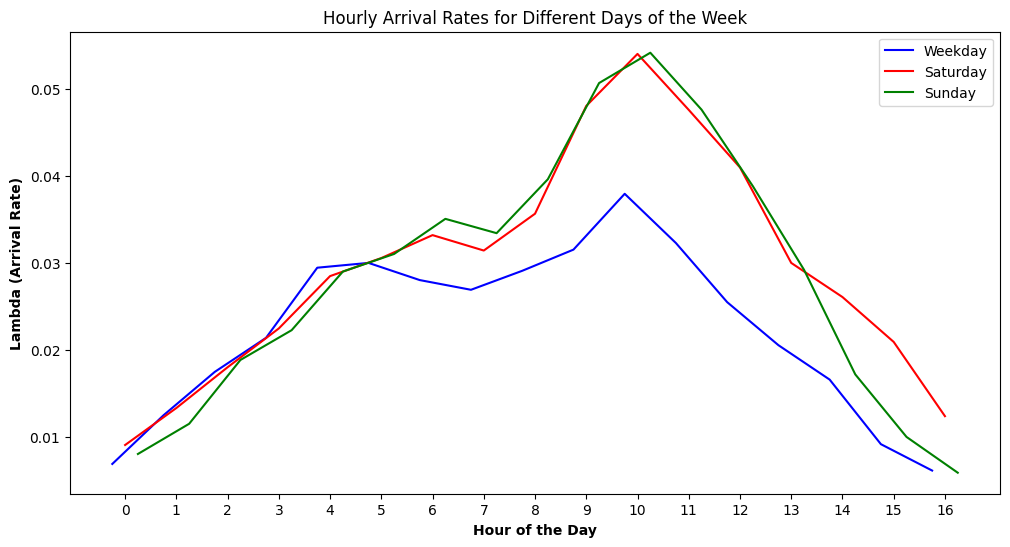

In [43]:
import matplotlib.pyplot as plt

# Convert the dictionaries to DataFrames
df_weekday = pd.DataFrame(list(lambdas_weekday.items()), columns=['Hour', 'Lambda'])
df_saturday = pd.DataFrame(list(lambdas_saturday.items()), columns=['Hour', 'Lambda'])
df_sunday = pd.DataFrame(list(lambdas_sunday.items()), columns=['Hour', 'Lambda'])

# Ensure hours are aligned
hours = sorted(set(df_weekday['Hour']) | set(df_saturday['Hour']) | set(df_sunday['Hour']))
df_weekday = df_weekday.set_index('Hour').reindex(hours).reset_index()
df_saturday = df_saturday.set_index('Hour').reindex(hours).reset_index()
df_sunday = df_sunday.set_index('Hour').reindex(hours).reset_index()

# Setting up the bar width
bar_width = 0.25

# Setting the position of the bars
r1 = np.arange(len(hours))
r2 = [x + bar_width for x in r1]
r3 = [x + bar_width for x in r2]

# Creating the bar chart
plt.figure(figsize=(12, 6))
plt.plot(r1, df_weekday['Lambda'], color='b', label='Weekday')
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Lambda (Arrival Rate)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hours))], hours)
plt.title('Hourly Arrival Rates for Different Days of the Week')

plt.plot(r2, df_saturday['Lambda'], color='r', label='Saturday')
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Lambda (Arrival Rate)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hours))], hours)
plt.title('Hourly Arrival Rates for Different Days of the Week')

plt.plot(r3, df_sunday['Lambda'], color='g', label='Sunday')
plt.xlabel('Hour of the Day', fontweight='bold')
plt.ylabel('Lambda (Arrival Rate)', fontweight='bold')
plt.xticks([r + bar_width for r in range(len(hours))], hours)
plt.title('Hourly Arrival Rates for Different Days of the Week')
plt.legend()
plt.show()

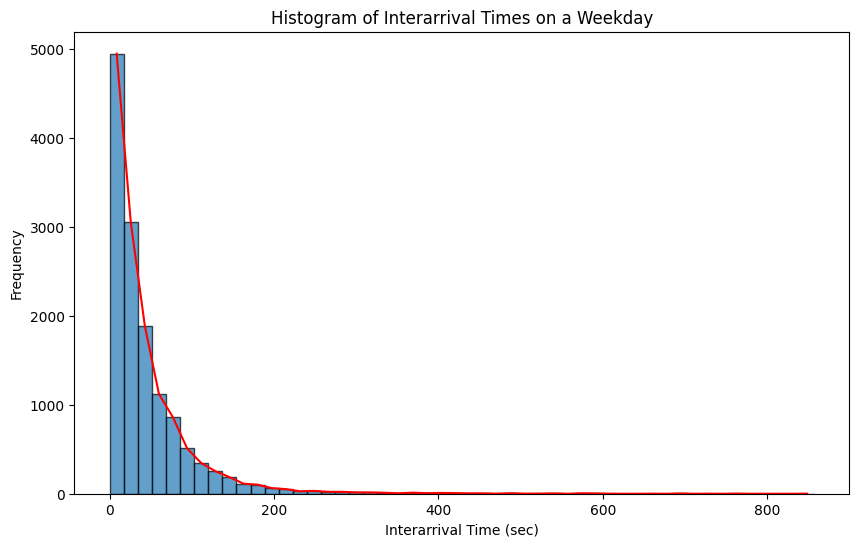

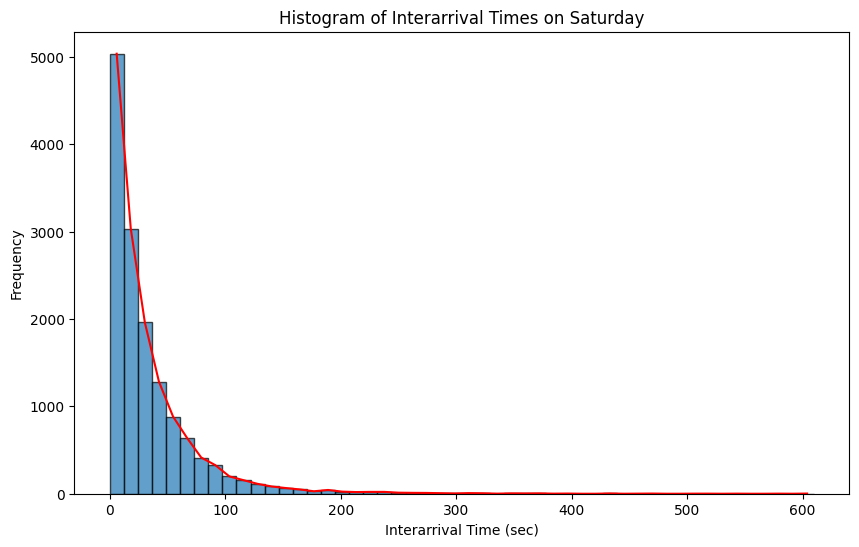

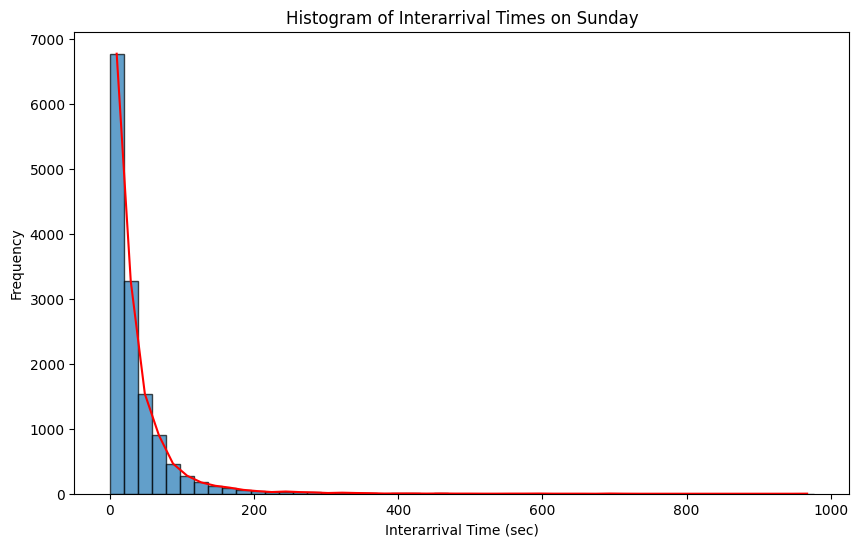

In [10]:
import matplotlib.pyplot as plt
# Creating the histogram
def hist_maker(df, day):
    plt.figure(figsize=(10, 6))
    
    # Calculate histogram data
    counts, bin_edges = np.histogram(df['Interarrival Time (sec)'], bins=50)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])  # Calculate bin centers

    # Plot histogram
    plt.hist(df['Interarrival Time (sec)'], bins=50, edgecolor='black', alpha=0.7)

    # Plot line through the top of each bar
    plt.plot(bin_centers, counts, color='red', linestyle='-')  # Removed marker

    # Adding titles and labels
    plt.title(f'Histogram of Interarrival Times on {day}')
    plt.xlabel('Interarrival Time (sec)')
    plt.ylabel('Frequency')
    
    plt.show()

hist_maker(weekday, "a Weekday")
hist_maker(saturday, "Saturday")
hist_maker(sunday, "Sunday")


In [10]:
test